# Cifar 10 Spectral embedding

In [1]:
%run Cifar10InceptionV3ClusterAndClassify.py

random_state=0
np.random.seed(random_state)
skf, skf_cv = spliters(random_state, train_size=500, cv_repeats=5)

/mnt/Data/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1635: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


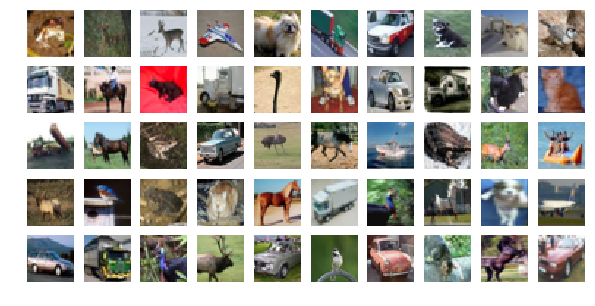

In [380]:
X_imgs, X, y = gen_cifar10()

In [387]:
X_imgs.shape

(60000, 32, 32, 3)

In [381]:
X.shape, y.shape
train, test = next(skf.split(X,y))
train.shape, test.shape

((500,), (10000,))

In [382]:
plot2D(X[train], y[train],method='tsne', plot_n_samples=300)

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

## Spectral embedding

In [383]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, randint

In [384]:
from sklearn.manifold import SpectralEmbedding

In [385]:
for l in X.T:
    print(l.mean(),l.std())
    break
    
l.reshape([-1,1]).shape

0.6673374 0.622403


(60000, 1)

In [386]:
manifold = SpectralEmbedding(n_components=1, affinity='nearest_neighbors', 
                  gamma=None, random_state=None, 
                  eigen_solver=None, n_neighbors=20)

alpha = np.concatenate([manifold.fit_transform(col.reshape([-1, 1])) for col in X[train].T], axis=-1)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [ ]:
alpha.shape

In [ ]:
axis=1
plt.plot(np.linalg.norm(alpha-X[train], axis=-axis)/X.shape[axis])

In [ ]:
plot2D(alpha, y[train], method='tsne', perplexity=30, plot_n_samples=250)
plot2D(alpha, y[train], method='pca', plot_n_samples=250)

## Low dim manifold problem

Input: X and maybe dual gap Z (per feature)

Parameters:

- mu: multiplier for the alternating direction method of multipliers (ADMM)
- l or lambda_: regularization + temperature $\hat{\lambda} = t/2\lambda = (8 \lambda\gamma)^{-1}$
    - lambda: regularization strenth
    - t or gamma: heat kernel param, $\gamma=\frac{1}{4t}$
- n_neighbors: for kNN graph

For each feature j of X:

$newX_j = (L+cW)^{-1}W(X_j - Z_j)$

$c = \mu/\hat{\lambda}$

In the paper  W is calculated based on 20 neighbors, with 1/gamma being calculated for each pair of points, being the product of the distances to the respective 10th neighbors.


A hard thing is getting the linear systems to converge in a reasonable number of iterations. for tol 1e-5 and maxiter=500 almost no coordinate has converged.

In [388]:
from sklearn.neighbors import NearestNeighbors
from sklearn.base import TransformerMixin
from scipy import sparse
from tqdm import tqdm


class LDMM(TransformerMixin):
    def __init__(self, mu=0.5, bar_lambda=0.01, n_neighbors=20, 
                 tol=1e-3, maxiter=200, n_jobs=1, feature_mask=None):
        '''
        - mu: multiplier for the alternating direction method of multipliers (ADMM)
        - l or lambda_: regularization + temperature $\hat{\lambda} = t/2\lambda = (8 \lambda\gamma)^{-1}$
            - lambda: regularization strenth
            - t or gamma: heat kernel param, $\gamma=\frac{1}{4t}$
        - n_neighbors: for kNN graph
        - feature mask:  array with indices for features to work on
        '''
        self.mu = mu
        self.bar_lambda = bar_lambda
        self.n_neighbors = n_neighbors
        self.n_jobs = n_jobs
        self.tol = tol
        self.maxiter = maxiter
        self.feature_mask = feature_mask
        self.solver_info_ = []
           
    
    def _compute_W(self, X):
        knn = NearestNeighbors(self.n_neighbors, algorithm='auto', metric='sqeuclidean',
                               leaf_size=30, n_jobs=self.n_jobs)
        knn.fit(X)
        distances, _ = knn.kneighbors(n_neighbors=(self.n_neighbors//2))
        half_k_neighbors_distance = np.sqrt(distances[:,-1].squeeze())
        W = knn.kneighbors_graph(n_neighbors=self.n_neighbors, mode='distance')
        # normalization based on each points "neighbohood radius"
        for i in range(W.shape[0]):
            W[i,:] /= half_k_neighbors_distance[i]
        W = W.tocsc()
        for j in range(W.shape[0]):
             W[:,j] /= half_k_neighbors_distance[i]
        # comput exp over non zero entries (zero entries are distances non calculated)
        W *= -1
        W = W.expm1()
        W[W.nonzero()] += 1 # operation modifies W in place                
        W.eliminate_zeros()
        return W
    
    def _compute_L(self, W):
        D = sparse.dia_matrix((W.sum(axis=1).squeeze(), 0),shape=W.shape)
        L = D - W
        return L
    
    def _solve_lin_sys(self, W, L, Xj, Zj):
        c = self.mu/self.bar_lambda
        A = (L + c*W).tocsc()
        b = c * W * (Xj-Zj)
        x0 = Xj
        # preconditioning matrix M should approximate inv A
        # spilu returns SuperLU object with solve(b) that approx solves Ax=b
        # To improve the better approximation to the inverse, you may need to
        # increase `fill_factor` AND decrease `drop_tol`.
        M_approx = sparse.linalg.spilu(A, drop_tol=1e-5, fill_factor=50)
        M = sparse.linalg.LinearOperator(shape=A.shape, matvec=M_approx.solve)
        x, info = sparse.linalg.cg(A, b, x0, M=M, tol=self.tol, maxiter=self.maxiter)
        self.solver_info_.append(info)
        return x

    def fit_transform(self, X, y=None):
        '''
        X : samples x features
        y if informed is the dual variable Z
        '''
        self.W_ = self._compute_W(X)
        self.L_ = self._compute_L(self.W_) 
        
        X_new = []       
        self.solver_info_ = []

        if self.feature_mask is not None:
            X = X[:,self.feature_mask]
            
        n_features = X.shape[1]

        if y is not None:
            Z = y
        else:
            Z = np.zeros(X.shape[0], n_features)
        
        for j in tqdm(range(n_features), desc='features'):            
            alphaj = self._solve_lin_sys(self.W_, self.L_, X[:,j], Z[:,j]).reshape(-1, 1)
            X_new.append(alphaj)
        X_new = np.concatenate(X_new, axis=-1)
        return X_new

In [393]:
model = LDMM(mu=1, bar_lambda=0.01, feature_mask=np.arange(2048))

In [394]:
alpha_k = model.fit_transform(np.concatenate([X[train],X_imgs[train].reshape(-1,32*32*3)], axis=-1))

features: 100%|██████████| 2048/2048 [00:16<00:00, 127.34it/s]


In [395]:
axis=0
plt.plot(np.linalg.norm(alpha_k-X[train], axis=-axis)/X[train].shape[axis])
plt.plot(np.array(model.solver_info_))
plt.yscale('log')
plt.title("mean (over samples) square distance btw old and new coord")

Text(0.5,1,'mean (over samples) square distance btw old and new coord')

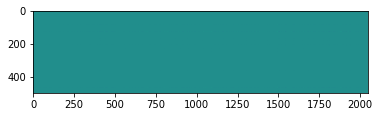

In [396]:
plt.imshow(alpha_k)

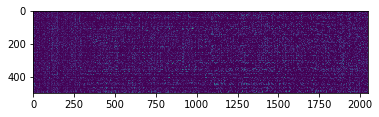

In [397]:
plt.imshow(X[train])

In [398]:
any(model.solver_info_)

False

In [2]:
from sklearn.linear_model import SGDClassifier,LinearRegression

In [ ]:
SGDClassifier()